# Polar coordinates

In [1]:
include("smij-functions.jl");

## p28: eigenmodes of Laplacian on the disk (compare p22.jl)

In [2]:
# r coordinate, ranging from -1 to 1 (N must be odd):
N = 25
N2 = div(N - 1, 2)
D, r = cheb(N)
D² = D^2
D1 = D²[2:N2+1, 2:N2+1]
D² = D²[2:N2+1, N:-1:N2+2]
E1 = D[2:N2+1, 2:N2+1]
E2 = D[2:N2+1, N:-1:N2+2]

# t = theta coordinate, ranging from 0 to 2π (M must be even):
M = 20
dθ = 2π / M
θ = dθ * (1:M)
M2 = M ÷ 2
entry(k) = k==0 ? -π^2 / 3dθ^2 - 1 / 6 : 0.5 * (-1)^(k+1) / sin(dθ * k/ 2)^2
D²t = [ entry(mod(i-j,M)) for i in 1:M, j in 1:M ]

# Laplacian in polar coordinates:
R = diagm(1 ./ r[2:N2+1])
Z = zeros(M2, M2)
L = kron(D1 + R * E1, I(M)) + kron(D² + R * E2, [Z I(M2); I(M2) Z]) + kron(R^2, D²t)

# Compute four eigenmodes:
index = [1, 3, 6, 10]
λ, V = eigen(-L, sortby=abs)
λ = λ[index]
V = V[:, index]
λ = sqrt.(real(λ / λ[1]))

4-element Vector{Float64}:
 1.0
 1.5933405056950356
 2.2954172674276077
 2.9172954551170522

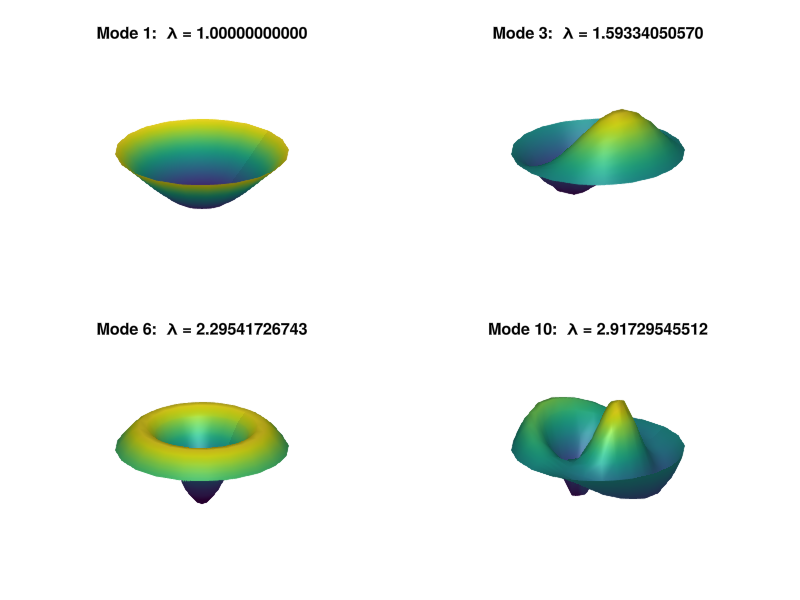

In [3]:
# Plot eigenmodes with nodal lines underneath:
using GLMakie, PyFormattedStrings

rr, θθ = r[1:N2+1], [0; θ]
XX = [r*cos(θ) for θ in θθ, r in rr]
YY = [r*sin(θ) for θ in θθ, r in rr]
z = cis.(π * (-200:200) / 200)
fig = Figure()
ax = vec([ Axis3(fig[j,i]) for i in 1:2, j in 1:2 ])
for i in 1:4
    u = reshape(real(V[:, i]), M, N2)
    u = [zeros(M + 1) u[[M; 1:M], :]]
    u = normalize(u, Inf)
    surface!(ax[i], XX, YY, u)
    ax[i].title = f"Mode {index[i]}:  λ = {λ[i]:.11f}"
    limits!(ax[i],-1.05, 1.05,-1.05, 1.05,-1.05, 1.05)
end
hidespines!.(ax)
hidedecorations!.(ax)
fig

## p28b: eigenmodes of Laplacian on the disk
function p28b()
    # r coordinate, ranging from -1 to 1 (N must be odd)
    N = 25
    N2 = Int((N - 1) / 2)
    (D, r) = cheb(N)
    D² = D^2
    D1 = D²[2:N2+1, 2:N2+1]
    D² = D²[2:N2+1, N:-1:N2+2]
    E1 = D[2:N2+1, 2:N2+1]
    E2 = D[2:N2+1, N:-1:N2+2]

    # t = theta coordinate, ranging from 0 to 2*pi (M must be even):
    M = 20
    dθ = 2 * pi / M
    t = dθ * (1:M)
    M2 = Int(M / 2)
    D²t = toeplitz([-pi^2 / (3 * dθ^2) - 1 / 6; @. 0.5 * (-1)^(2:M) / sin(dθ * (1:M-1) / 2)^2])

    # Laplacian in polar coordinates:
    R = diagm(1 ./ r[2:N2+1])
    Z = zeros(M2, M2)
    L = kron(D1 + R * E1, I(M)) + kron(D² + R * E2, [Z I(M2); I(M2) Z]) + kron(R^2, D²t)

    # Compute 25 eigenmodes:
    index = 1:25
    λ, V = eigen(-L)
    ii = sortperm(abs.(λ))[index]
    λ = λ[ii]
    V = V[:, ii]
    λ = sqrt.(real(λ / λ[1]))

    # Plot nodal lines:
    (rr, tt) = (r[1:N2+1], [0; t])
    (xx, yy) = @. (cos(tt) * rr', sin(tt) * rr')
    z = exp.(1im * pi * (-100:100) / 100)
    clf()
    for i = 1:25
        subplot(5, 5, i)
        u = reshape(real(V[:, i]), M, N2)
        u = [zeros(M + 1) u[[M; 1:M], :]]
        u = u / norm(u[:], Inf)
        plot(real(z), imag(z))
        xlim(-1.07, 1.07)
        ylim(-1.07, 1.07)
        axis("off")
        axis("equal")
        contour(xx, yy, u, levels=[0])
        title("$(round(λ[i],sigdigits=5))", fontsize=8)
    end
end

## p29: solve Poisson equation on the unit disk
function p29()
    # Laplacian in polar coordinates:
    N = 25
    N2 = Int((N - 1) / 2)
    (D, r) = cheb(N)
    D² = D^2
    D1 = D²[2:N2+1, 2:N2+1]
    D² = D²[2:N2+1, N:-1:N2+2]
    E1 = D[2:N2+1, 2:N2+1]
    E2 = D[2:N2+1, N:-1:N2+2]
    M = 20
    dθ = 2 * pi / M
    t = dθ * (1:M)
    M2 = Int(M / 2)
    D²t = toeplitz([-pi^2 / (3 * dθ^2) - 1 / 6; @. 0.5 * (-1)^(2:M) / sin(dθ * (1:M-1) / 2)^2])
    R = diagm(1 ./ r[2:N2+1])
    Z = zeros(M2, M2)
    L = kron(D1 + R * E1, I(M)) + kron(D² + R * E2, [Z I(M2); I(M2) Z]) + kron(R^2, D²t)

    # Right-hand side and solution for u:
    (rr, tt) = (r[2:N2+1]', t)
    f = @. -rr^2 * sin(tt / 2)^4 + sin(6 * tt) * cos(tt / 2)^2
    u = L \ f[:]

    # Reshape results onto 2D grid and plot them:
    u = reshape(u, M, N2)
    u = [zeros(M + 1) u[[M; 1:M], :]]
    (rr, tt) = (r[1:N2+1], t[[M; 1:M]])
    (xx, yy) = @. (cos(tt) * rr', sin(tt) * rr')
    clf()
    surf(xx, yy, u)
    view(20, 40)
    xlim(-1, 1)
    ylim(-1, 1)
    zlim(-0.01, 0.05)
    xlabel("x")
    ylabel("y")
    zlabel("z")
end